# Rarefaction analysis reveals that clone discovery is saturated with respect to sequencing depth

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
import random

## Set output parameters

In [3]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/pop_dyn_rarefaction"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [4]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Counts of clone barcodes

Load preprocessed data.

Preprocessing steps (previously done) consist of:
- Call library barcode.
- Error correction of clone barcode by consensus.
- Sum counts for error corrected clone barcode cluster.
- Call genuine barcodes (filtering to remove errors due to PCR and sequencing noise).

In [5]:
infile = "../preprocessed_data/pop_dyn_data/clone_barcodes.tsv.gz"

obs_raw = pd.read_csv(infile, sep="\t", header=0, index_col=None)

print(obs_raw.shape)
obs_raw.head()

(4229949, 11)


,well,library_barcode_call,clone_barcode_consensus,lib,count,time,supernatant_or_cells,call_genuine_clone_barcode_raw,call_genuine_clone_barcode_dynamics,call_genuine_clone_barcode_fidelity,n_timepoints_seen
0,puro,LB1,AGACAGTGTGACAGTGTGTGACTCTGA,sFH11-1,565,0,supernatant,True,True,False,6
1,puro,LB1,TGAGAGTGTCTGACTCAGTCTCTGTGT,sFH11-1,540,0,supernatant,True,True,False,2
2,puro,LB1,TGTCTGAGTCTGTCTGTGTCACTGTCT,sFH11-1,491,0,supernatant,True,True,False,5
3,puro,LB1,AGAGTCTGACTCACTCAGTGTCTGTCT,sFH11-1,478,0,supernatant,True,True,False,6
4,puro,LB1,ACTGTCTGTCAGACACTCTGTCACTCT,sFH11-1,461,0,supernatant,True,True,False,2


# Preprocess data

## Select data used for this analysis

In [6]:
# Specify libraries from dynamics analysis
libs_keep = ["sFH11-1", "sFH11-2",
             "sFH11-3", "sFH11-4", 
             "sFH11-5", "sFH11-6",
             "sFH11-8", "sFH11-9", 
             "sFH11-10", "sFH11-11", 
             "sFH11-12", "sFH11-13", 
             "sFH11-15", "sFH11-16", 
             "sFH11-17", "sFH11-18", 
             "sFH11-19", "sFH11-20"]

# Select libraries from dynamics analysis
obs_raw = obs_raw.loc[obs_raw["lib"].isin(libs_keep) == True]

# Select barcodes flagged as genuine and relevant to this analysis
obs = obs_raw.loc[obs_raw["call_genuine_clone_barcode_dynamics"] == True]

print(obs.shape)
obs.head()

(38669, 11)


,well,library_barcode_call,clone_barcode_consensus,lib,count,time,supernatant_or_cells,call_genuine_clone_barcode_raw,call_genuine_clone_barcode_dynamics,call_genuine_clone_barcode_fidelity,n_timepoints_seen
0,puro,LB1,AGACAGTGTGACAGTGTGTGACTCTGA,sFH11-1,565,0,supernatant,True,True,False,6
1,puro,LB1,TGAGAGTGTCTGACTCAGTCTCTGTGT,sFH11-1,540,0,supernatant,True,True,False,2
2,puro,LB1,TGTCTGAGTCTGTCTGTGTCACTGTCT,sFH11-1,491,0,supernatant,True,True,False,5
3,puro,LB1,AGAGTCTGACTCACTCAGTGTCTGTCT,sFH11-1,478,0,supernatant,True,True,False,6
4,puro,LB1,ACTGTCTGTCAGACACTCTGTCACTCT,sFH11-1,461,0,supernatant,True,True,False,2


# Sample reads and count unique barcodes

## Do sampling

In [7]:
# Set sampling parameters

# Testing
n_reads = [1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
n_replicates = 1

# Production
n_reads = [1, 2, 5,
           1e1, 2e1, 5e1,
           1e2, 2e2, 5e2,
           1e3, 2e3, 5e3,
           1e4, 2e4, 5e4,
           1e5, 2e5, 5e5,
           1e6, 2e6, 5e6]
n_replicates = 10

In [8]:
# Calculate total read count for each library (to set maximum for subsampling)
total_count = obs.groupby("lib")["count"].sum()
total_count

lib
sFH11-1      305892
sFH11-10     665439
sFH11-11    1270880
sFH11-12     429890
sFH11-13     326379
sFH11-15     340132
sFH11-16     491291
sFH11-17     835587
sFH11-18    1008960
sFH11-19    1274676
sFH11-2      845091
sFH11-20    1015053
sFH11-3      840343
sFH11-4      574435
sFH11-5      315045
sFH11-6      461029
sFH11-8      279931
sFH11-9     1132589
Name: count, dtype: int64

In [9]:
%%time

# Do sampling

obs_subsampled = pd.DataFrame(columns=["lib", "library_barcode_call", "n_reads", "unique_barcodes", "n_replicate"])

for (lib, library_barcode_call), group in obs.groupby(["lib", "library_barcode_call"]):
    
    print (lib, library_barcode_call, group["count"].sum())
    
    # Set number of reads to sample to be up to, but not greater than, total number of reads in library
    n_reads_censored = [n for n in n_reads if n < total_count[lib]]
    
    for _n_reads in n_reads_censored:
        
        for _n_replicate in range(n_replicates):

            unique_barcodes = len(set(random.choices(list(group.index), weights=group["count"], k=int(_n_reads))))

            row = pd.Series({"lib": lib,
                             "well": group["well"].iloc[0],
                             "time": group["time"].iloc[0],
                             "library_barcode_call": library_barcode_call,
                             "n_reads": _n_reads,
                             "unique_barcodes": unique_barcodes,
                             "n_replicate": _n_replicate})

            obs_subsampled = obs_subsampled.append(row, ignore_index=True)
        
# obs_subsampled = obs_subsampled.set_index(["lib", "library_barcode_call"])

print(obs_subsampled.shape)
obs_subsampled.head()

sFH11-1 LB1 79142
sFH11-1 LB2 226750
sFH11-10 LB1 29682
sFH11-10 LB2 635757
sFH11-11 LB1 48714
sFH11-11 LB2 1222166
sFH11-12 LB1 1439
sFH11-12 LB2 428451
sFH11-13 LB1 747
sFH11-13 LB2 325632
sFH11-15 LB1 105485
sFH11-15 LB2 234647
sFH11-16 LB1 135126
sFH11-16 LB2 356165
sFH11-17 LB1 250377
sFH11-17 LB2 585210
sFH11-18 LB1 320922
sFH11-18 LB2 688038
sFH11-19 LB1 419582
sFH11-19 LB2 855094
sFH11-2 LB1 399988
sFH11-2 LB2 445103
sFH11-20 LB1 378838
sFH11-20 LB2 636215
sFH11-3 LB1 717388
sFH11-3 LB2 122955
sFH11-4 LB1 555097
sFH11-4 LB2 19338
sFH11-5 LB1 312089
sFH11-5 LB2 2956
sFH11-6 LB1 458995
sFH11-6 LB2 2034
sFH11-8 LB1 93932
sFH11-8 LB2 185999
sFH11-9 LB1 55656
sFH11-9 LB2 1076933
(6420, 7)
CPU times: user 4min 16s, sys: 272 ms, total: 4min 16s
Wall time: 4min 16s


,lib,library_barcode_call,n_reads,unique_barcodes,n_replicate,time,well
0,sFH11-1,LB1,1,1,0,0.0,puro
1,sFH11-1,LB1,1,1,1,0.0,puro
2,sFH11-1,LB1,1,1,2,0.0,puro
3,sFH11-1,LB1,1,1,3,0.0,puro
4,sFH11-1,LB1,1,1,4,0.0,puro


## Append counts for full sample

In [10]:
# Faster than running subsampling

for (lib, library_barcode_call), group in obs.groupby(["lib", "library_barcode_call"]):

    row = pd.Series({"lib": lib,
                     "well": group["well"].iloc[0],
                     "time": group["time"].iloc[0],
                     "library_barcode_call": library_barcode_call,
                     "n_reads": total_count[lib],
                     "unique_barcodes": group.shape[0],
                     "n_replicate": 0})

    obs_subsampled = obs_subsampled.append(row, ignore_index=True)

print(obs_subsampled.shape)
obs_subsampled.head()

(6456, 7)


,lib,library_barcode_call,n_reads,unique_barcodes,n_replicate,time,well
0,sFH11-1,LB1,1,1,0,0.0,puro
1,sFH11-1,LB1,1,1,1,0.0,puro
2,sFH11-1,LB1,1,1,2,0.0,puro
3,sFH11-1,LB1,1,1,3,0.0,puro
4,sFH11-1,LB1,1,1,4,0.0,puro


## Annotate subsampled data

In [11]:
# Label library barcode with population name (drug resistance)
library_barcode_call_to_population_name = {"LB1": "puromycin_resistant",
                                           "LB2": "zeocin_resistant"}

obs_subsampled["population_name"] = obs_subsampled["library_barcode_call"].map(library_barcode_call_to_population_name)

In [12]:
# Create categorical datatype for time labels
obs_subsampled["time_label"] = obs_subsampled["time"].astype(np.uint8)

# Plot rarefaction curves

In [13]:
# Define plotting function

def plot_pretty_lineplot(data, legend=False):

    fig, ax = plt.subplots(1, 1, figsize=(2,1.5))

    sns.lineplot(ax=ax,
                 data=data,
                 x="n_reads",
                 y="unique_barcodes",
                 hue="time_label",
                 palette="viridis",
                 errorbar="sd",
                 err_style="band"                
                )

    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlabel("Reads sampled")
    ax.set_ylabel("Unique barcodes detected")

    ax.get_legend().remove()
    
    if legend:
        fig.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=1, title="Time (days)")

    ax.set_xticks([1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7])
    locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

    ax.set_yticks([1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7])
    locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

    ax.set_xlim(1, 1e7)
    ax.set_ylim(1, 1e4)
    
    return fig, ax

## Make plots

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


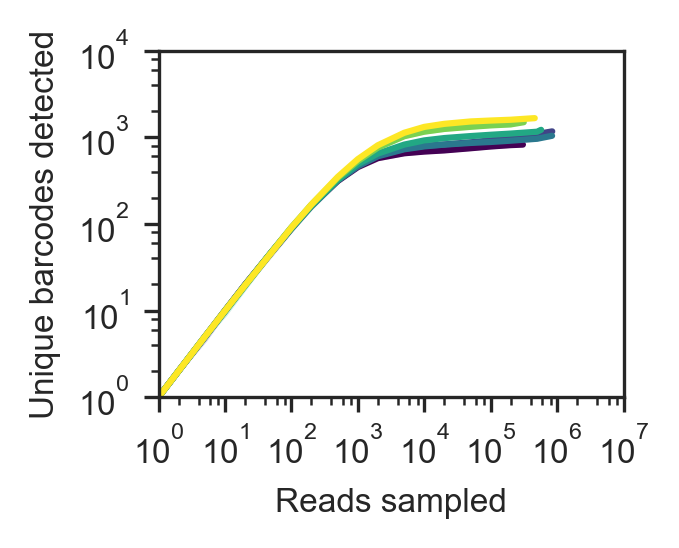

In [14]:
experiment_category = "dynamics"
well = "puro"
population_name = "puromycin_resistant"

selector = (obs_subsampled["well"] == well) & (obs_subsampled["population_name"] == population_name)

data = obs_subsampled.loc[selector]

fig, ax = plot_pretty_lineplot(data)

outfile = "saturation_curve_" + experiment_category + "_" + well + "_" + population_name
save_figure(fig, outfile)

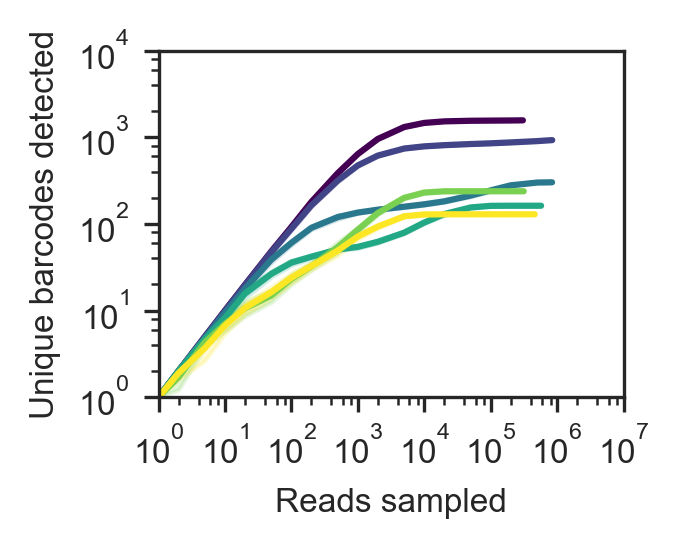

In [15]:
experiment_category = "dynamics"
well = "puro"
population_name = "zeocin_resistant"

selector = (obs_subsampled["well"] == well) & (obs_subsampled["population_name"] == population_name)

data = obs_subsampled.loc[selector]

fig, ax = plot_pretty_lineplot(data)

outfile = "saturation_curve_" + experiment_category + "_" + well + "_" + population_name
save_figure(fig, outfile)

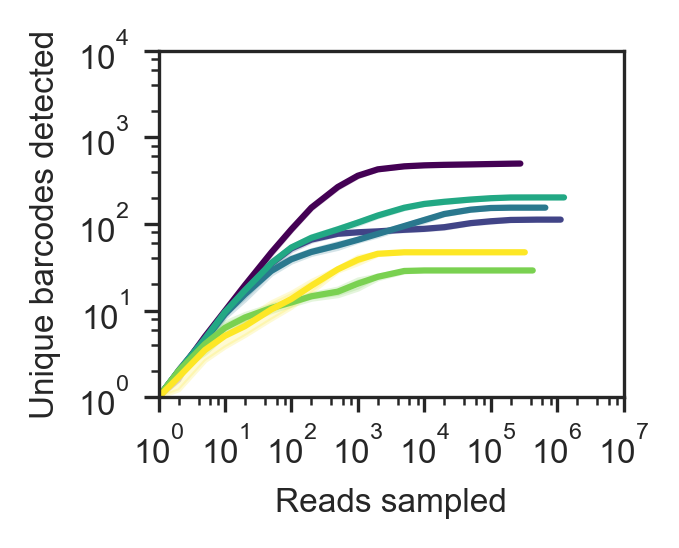

In [16]:
experiment_category = "dynamics"
well = "zeo"
population_name = "puromycin_resistant"

selector = (obs_subsampled["well"] == well) & (obs_subsampled["population_name"] == population_name)

data = obs_subsampled.loc[selector]

fig, ax = plot_pretty_lineplot(data)

outfile = "saturation_curve_" + experiment_category + "_" + well + "_" + population_name
save_figure(fig, outfile)

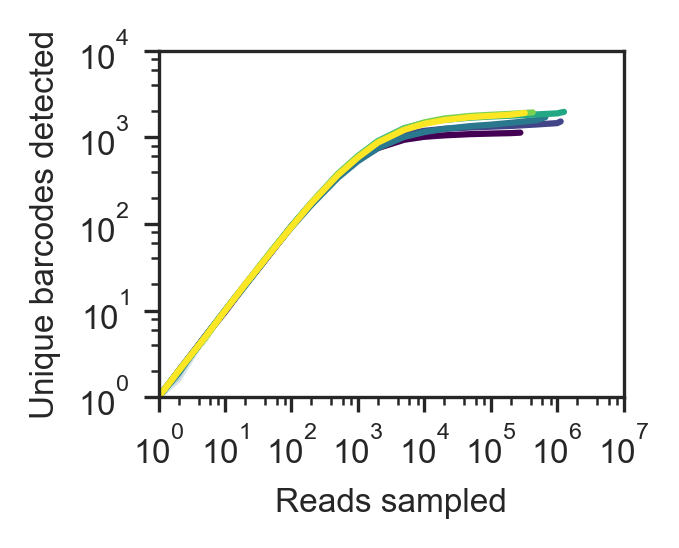

In [17]:
experiment_category = "dynamics"
well = "zeo"
population_name = "zeocin_resistant"

selector = (obs_subsampled["well"] == well) & (obs_subsampled["population_name"] == population_name)

data = obs_subsampled.loc[selector]

fig, ax = plot_pretty_lineplot(data)

outfile = "saturation_curve_" + experiment_category + "_" + well + "_" + population_name
save_figure(fig, outfile)

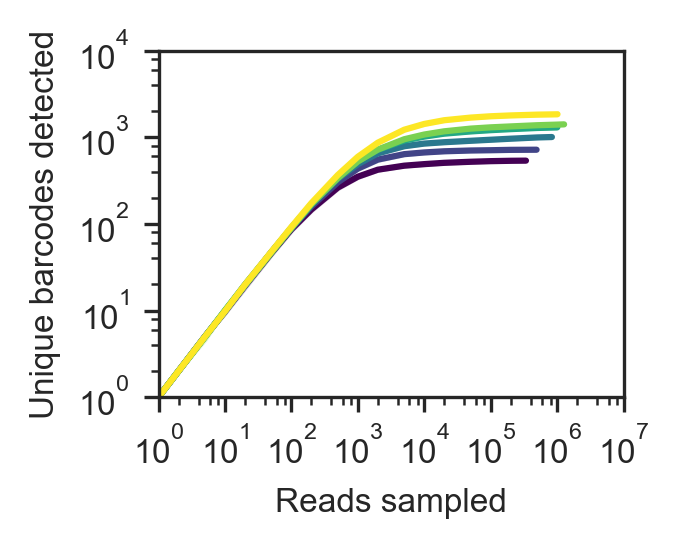

In [18]:
experiment_category = "dynamics"
well = "no_drug"
population_name = "puromycin_resistant"

selector = (obs_subsampled["well"] == well) & (obs_subsampled["population_name"] == population_name)

data = obs_subsampled.loc[selector]

fig, ax = plot_pretty_lineplot(data)

outfile = "saturation_curve_" + experiment_category + "_" + well + "_" + population_name
save_figure(fig, outfile)

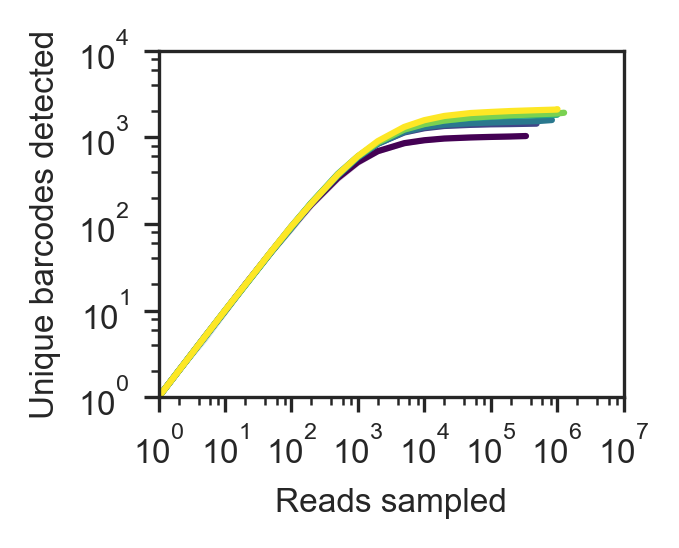

In [19]:
experiment_category = "dynamics"
well = "no_drug"
population_name = "zeocin_resistant"

selector = (obs_subsampled["well"] == well) & (obs_subsampled["population_name"] == population_name)

data = obs_subsampled.loc[selector]

fig, ax = plot_pretty_lineplot(data)

outfile = "saturation_curve_" + experiment_category + "_" + well + "_" + population_name
save_figure(fig, outfile)

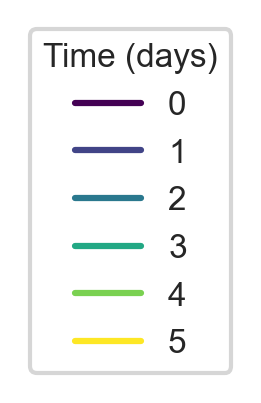

In [20]:
# Plot legend

time_dummy = [0, 1, 2, 3, 4, 5]
df_dummy = pd.DataFrame({"x": [0]*len(time_dummy),
                         "y": [0]*len(time_dummy),
                         "time": time_dummy})

fig, ax = plt.subplots(1, 1, figsize=(0.75,1.25))

sns.lineplot(data=df_dummy, x="x", y="y", hue="time", palette="viridis")

ax.axis("off")

ax.get_legend().remove()
fig.legend(loc="center",  ncol=1, title="Time (days)")

save_figure(fig, "legend_time")